In [1]:
import os
from datetime import datetime
import joblib
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats, linalg

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.distributions
import pytorch_lightning as pl

import src
from src.attrs import PATHS, GLOBALS
from src import utils

from src.data import loading
from src.tools import comp
from src.models import base, autoencoder
from src.train import datasets, losses

~/.conda/envs/koopman/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
~/.conda/envs/koopman/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
plt.style.use('bmh')

In [3]:
SUBPROJECT = 'cnn_pacific_daily_subsampled'
N_LATENTS = 20
k = 20

In [4]:
nus = np.arange(1, k+1)
matrix_norms = np.empty_like(nus, dtype=np.float64)
submatrix_norms = np.empty((len(nus), N_LATENTS-1))

for i, nu in enumerate(nus):
    lim = joblib.load(os.path.join(PATHS[SUBPROJECT], 'lim', f'lim_pca_d{N_LATENTS}_nu{nu}.joblib'))
    matrix_norms[i] = linalg.norm(lim.A)
    for j in np.arange(1, N_LATENTS):
        submatrix_norms[i, j-1] = linalg.norm(lim.A[0:j])

In [9]:
submatrix_norms.shape

(20, 19)

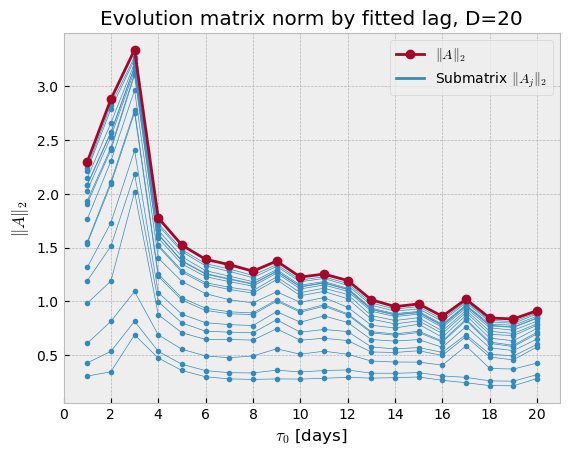

In [10]:
fig, ax = plt.subplots()

for j in np.arange(1, N_LATENTS-2):
    ax.plot(nus, submatrix_norms[:,j], marker='.', lw=0.5, color='C0')

ax.plot(nus, submatrix_norms[:,-1], marker='o', color='C1', label=r'$\|A\|_2$')
ax.plot([], [], label=r'Submatrix $\|A_j\|_2$')

ax.set(
    title=f'Evolution matrix norm by fitted lag, D={N_LATENTS}',
    xlabel=r'$\tau_0$ [days]', 
    ylabel=r'$\|A\|_2$', 
    xticks=np.arange(0, 22, 2),
)

ax.legend()

# Make plot for all experiments

In [57]:
kwargs_1 = dict(color='C0', marker='o')
kwargs_2 = dict(color='C1', marker='o')
opt_kwargs = dict(marker='*', markersize=10, color='k')

6
5
5
4


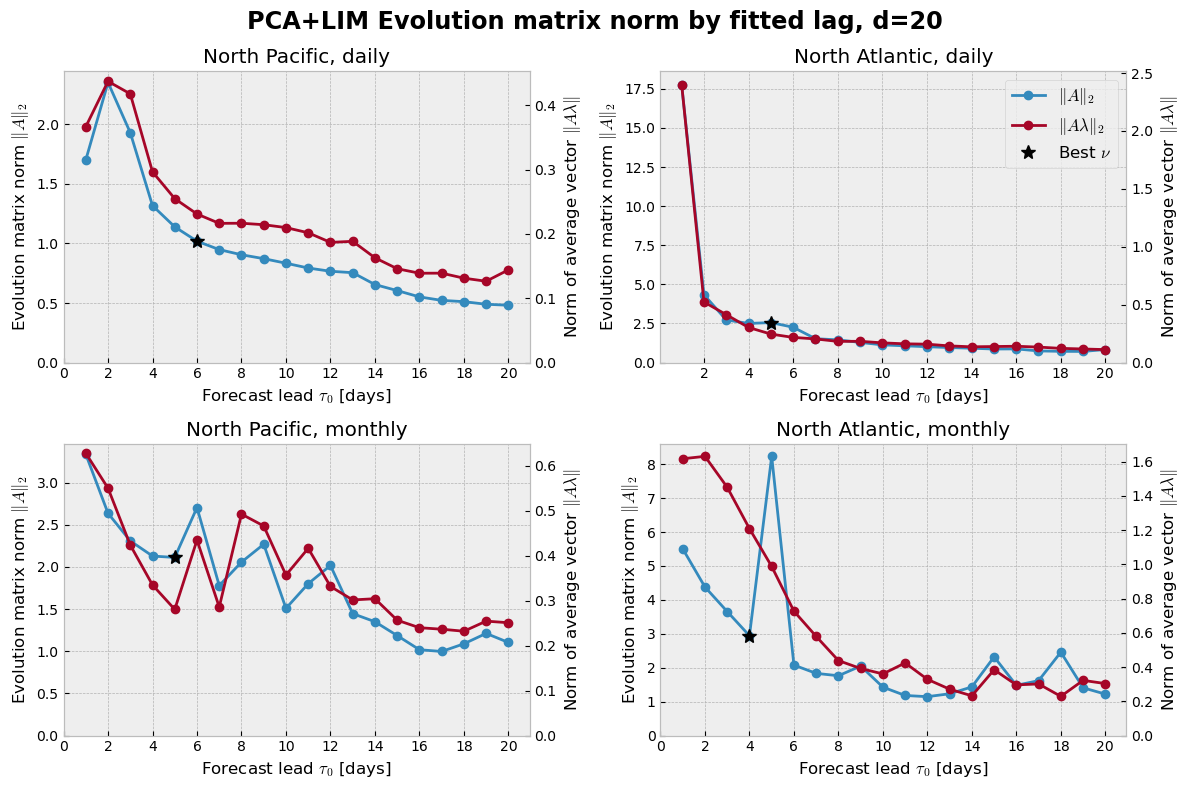

In [64]:
subprojects_list = [
    'cnn_pacific_daily_subsampled',
    'cnn_north_atlantic_daily_subsampled',
    'cnn_pacific_monthly',
    'cnn_north_atlantic_monthly'
]
N_LATENTS = 20
k = 20

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
axes = axes.ravel()

for i_ax, subproject in enumerate(subprojects_list):
    # Compute submatrix norms
    nus = np.arange(1, k+1)
    matrix_norms = np.empty_like(nus, dtype=np.float64)
    submatrix_norms = np.empty((len(nus), N_LATENTS-1))

    # Compute matrix norms
    for i, nu in enumerate(nus):
        lim = joblib.load(os.path.join(PATHS[subproject], 'lim', f'lim_pca_ssh_d{N_LATENTS}_nu{nu}.joblib'))
        matrix_norms[i] = linalg.norm(lim.A)
            
    axes[i_ax].plot(nus, matrix_norms, label=r'$\|A\|_2$', **kwargs_1)

    # Best matrix norm
    lim_best = joblib.load(os.path.join(PATHS[subproject], 'lim', f'lim_pca_ssh_d{N_LATENTS}_best.joblib'))
    print(lim_best.nu)
    axes[i_ax].plot([lim_best.nu], [linalg.norm(lim_best.A)], **opt_kwargs)
    
    axes[i_ax].set(
        title=subproject,
        ylabel=r'Evolution matrix norm $\|A\|_2$', 
        ylim=(0, None)
    )

    # Plot norm of "average vector"
    pca = joblib.load(os.path.join(PATHS[subproject], 'pca', f'pca_ssh_{N_LATENTS}.joblib'))
    matrix_norms = np.empty_like(nus, dtype=np.float64)
    typical_vector = np.sqrt(pca.explained_variance_ratio_)
    typical_vector = typical_vector / linalg.norm(typical_vector)
    
    for i, nu in enumerate(nus):
        lim = joblib.load(os.path.join(PATHS[subproject], 'lim', f'lim_pca_ssh_d{N_LATENTS}_nu{nu}.joblib'))
        typical_vector_norm = linalg.norm(lim.A @ typical_vector)
        matrix_norms[i] = typical_vector_norm
    
    
    ax_r = axes[i_ax].twinx()
    ax_r.grid(False)
    ax_r.plot(nus, matrix_norms, **kwargs_2)
    ax_r.set(
        ylim=(0,None),
        ylabel=r'Norm of average vector $\|A\lambda\|$'
    )

for i, ax in enumerate(axes):
    # ax.grid(False)
    if i in [0, 1]:
        xlabel = r'Forecast lead $\tau_0$ [days]'
        xticks = np.arange(0, 22, 2)

    ax.set(xticks=xticks, xlabel=xlabel)
    
axes[0].set_title('North Pacific, daily')
axes[1].set_title('North Atlantic, daily')
axes[2].set_title('North Pacific, monthly')
axes[3].set_title('North Atlantic, monthly')

axes[1].plot([], [], label=r"$\|A\lambda\|_2$", **kwargs_2)
axes[1].plot([], [], label=r'Best $\nu$', ls='', **opt_kwargs)

axes[1].legend(fontsize='large')
fig.suptitle(f'PCA+LIM Evolution matrix norm by fitted lag, d={N_LATENTS}', fontsize='xx-large', fontweight='bold')
fig.tight_layout()
plt.savefig(os.path.join(PATHS['visualization'], 'Figures', 'lim_matrix_norms.pdf'))